In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathos.multiprocessing as mp
import xarray as xr
#from telemetry_module import *
from copy import deepcopy
import pickle
import matplotlib as mpl
from scipy import interpolate
import time
from scipy.stats import gaussian_kde
from statsmodels.graphics import tsaplots
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import geopandas as gpd
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [3]:
from scipy.special import logit, expit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.linear_model import ARDRegression, LinearRegression, BayesianRidge, Lasso
from sklearn.linear_model import LassoCV, Ridge, RidgeCV, LassoLarsIC

In [4]:
from bayesfilt.telemetry.utils import *
from bayesfilt.filters.utils import get_covariance_ellipse
from bayesfilt.telemetry.utils import get_bound_from_positions, plot_relation
from simulate_tracks import *
from csg_resample_ks import *
data_dir = os.path.join(CSG_DIR, 'raw_data')

In [5]:
fpath = os.path.join(TELEMETRY_DIR, f'csg_ge_vr.prq_tracks')
vdf = pd.read_parquet(fpath, engine='fastparquet')

In [6]:
fpath = os.path.join(TELEMETRY_DIR, f'csg_ge_vr.prq_tracks_ca')
cdf = pd.read_parquet(fpath, engine='fastparquet')

## Log-likelihood maximization

In [7]:
def resample_x(dftrack, sigma):
    track_id = dftrack['TrackID'].iloc[0]
    sampler = partial(ConstantAccelerationResampler, dt=1., smoother=True)
    rs_x = sampler(error_strength=sigma, flag='X')  # 0.75
    rs_x.resample(
        times=dftrack['TrackTimeElapsed'].values,
        locs=dftrack['PositionX'].values,
        error_std=dftrack['ErrorHDOP'].values * 2.5 / np.sqrt(2),
        start_state_std=[4., 2., 2.],
        object_id=track_id
    )
    return rs_x.kf.dfs.MetricLogLik.mean()
def resample_y(dftrack, sigma):
    track_id = dftrack['TrackID'].iloc[0]
    sampler = partial(ConstantAccelerationResampler, dt=1., smoother=True)
    rs_x = sampler(error_strength=sigma, flag='Y')  # 0.75
    rs_x.resample(
        times=dftrack['TrackTimeElapsed'].values,
        locs=dftrack['PositionY'].values,
        error_std=dftrack['ErrorHDOP'].values * 2.5 / np.sqrt(2),
        start_state_std=[4., 2., 2.],
        object_id=track_id
    )
    return rs_x.kf.dfs.MetricLogLik.mean()

In [8]:
list_of_track_ids = np.random.choice(vdf['TrackID'].unique()[1:],int(36*2))
list_of_dftrack = [vdf[vdf['TrackID'] == ix] for ix in list_of_track_ids if ix != 0]
list_of_sigma = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.4, 2.]

In [9]:
list_of_loglik_x = []
for isigma in list_of_sigma:
    results = run_loop(
            func=partial(resample_x, sigma=isigma),
            input_list=list_of_dftrack,
            desc=f'CAresampler, {int(isigma*100)}'
        )
    list_of_loglik_x.append(results)

CAresampler, 200: 100%|██████████| 72/72 [00:01<00:00, 49.66it/s]


In [10]:
list_of_loglik_y = []
for isigma in list_of_sigma:
    results = run_loop(
            func=partial(resample_y, sigma=isigma),
            input_list=list_of_dftrack,
            desc=f'CAresampler, {int(isigma*100)}'
        )
    list_of_loglik_y.append(results)

CAresampler, 200: 100%|██████████| 72/72 [00:01<00:00, 52.97it/s]


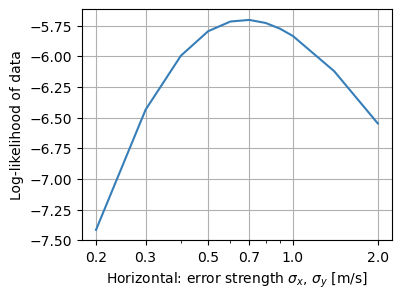

In [11]:
fig, ax = plt.subplots(figsize=(4,3))
idata = [np.mean(ix) + np.mean(iy) for ix,iy in zip(list_of_loglik_x,list_of_loglik_y)]
ax.semilogx(list_of_sigma, idata, '-r', color=clrs[0])
ax.set_xticks([0.2, 0.3, 0.5, 0.7, 1., 2.])
# f1 = mpl.ticker.ScalarFormatter()
# f1.set_scientific(False)
# ax.xaxis.set_major_formatter(f1)
f2 = mpl.ticker.StrMethodFormatter('{x:.1f}')
ax.xaxis.set_major_formatter(f2)
ax.grid(True)
ax.set_xlabel(r'Horizontal: error strength $\sigma_x$, $\sigma_y$ [m/s]')
ax.set_ylabel('Log-likelihood of data')
fig.savefig(os.path.join(FIG_DIR,f'loglik_hor.png'), dpi=200, bbox_inches='tight')

In [12]:
def resample_z(dftrack, sigma):
    track_id = dftrack['TrackID'].iloc[0]
    sampler = partial(ConstantAccelerationResampler, dt=1., smoother=True)
    rs_x = sampler(error_strength=sigma, flag='Z')  # 0.75
    rs_x.resample(
        times=dftrack['TrackTimeElapsed'].values,
        locs=dftrack['Altitude'].values,
        error_std=dftrack['ErrorVDOP'].values * 4.5,
        start_state_std=[4., 2., 2.],
        object_id=track_id
    )
    return rs_x.kf.dfs.MetricLogLik.mean()
list_of_sigma_z = [0.006, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.07, 0.1, 0.2]
list_of_loglik_z = []
for isigma in list_of_sigma_z:
    results = run_loop(
            func=partial(resample_z, sigma=isigma),
            input_list=list_of_dftrack,
            desc=f'CAresampler, {int(isigma*1000)}'
        )
    list_of_loglik_z.append(results)

CAresampler, 200: 100%|██████████| 72/72 [00:01<00:00, 57.19it/s]


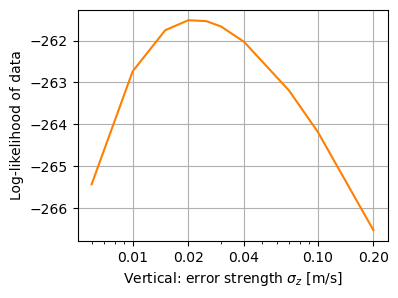

In [13]:
fig, ax = plt.subplots(figsize=(4,3))
idata_z = [np.sum(ix) for ix in list_of_loglik_z]
ax.semilogx(list_of_sigma_z, idata_z, '-b', color=clrs[1])
ax.set_xticks([0.01, 0.02, 0.04, 0.1, 0.2])
# f1 = mpl.ticker.ScalarFormatter()
# f1.set_scientific(False)
# ax.xaxis.set_major_formatter(f1)
f2 = mpl.ticker.StrMethodFormatter('{x:.2f}')
ax.xaxis.set_major_formatter(f2)
ax.grid(True)
ax.set_xlabel(r'Vertical: error strength $\sigma_z$ [m/s]')
ax.set_ylabel('Log-likelihood of data')
fig.savefig(os.path.join(FIG_DIR,f'loglik_ver.png'), dpi=200, bbox_inches='tight')

## HDOP and VDOP distributions

In [14]:
xgrid = np.linspace(0,6,100)
kde_fac=0.12
ibool = (vdf['Group'].isin(['wy'])) & (vdf['TrackID']>0)
kernel_hor = gaussian_kde(vdf.loc[ibool,'ErrorHDOP'].values, bw_method=kde_fac)
y_hor_wy = kernel_hor(xgrid)
kernel_ver = gaussian_kde(vdf.loc[ibool,'ErrorVDOP'].values, bw_method=kde_fac)
y_ver_wy = kernel_ver(xgrid)
ibool = (vdf['Group'].isin(['pa'])) & (vdf['TrackID']>0)
kernel_hor = gaussian_kde(vdf.loc[ibool,'ErrorHDOP'].values, bw_method=kde_fac)
y_hor_pa = kernel_hor(xgrid)
kernel_ver = gaussian_kde(vdf.loc[ibool,'ErrorVDOP'].values, bw_method=kde_fac)
y_ver_pa = kernel_ver(xgrid)

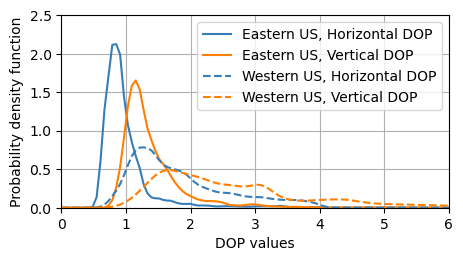

In [15]:
fig, ax = plt.subplots(figsize=(5,2.5))
ax.plot(xgrid, y_hor_pa, '-b', color=clrs[0], label='Eastern US, Horizontal DOP')
ax.plot(xgrid, y_ver_pa, '-r', color=clrs[1],label='Eastern US, Vertical DOP')
ax.plot(xgrid, y_hor_wy, '--b', color=clrs[0],label='Western US, Horizontal DOP')
ax.plot(xgrid, y_ver_wy, '--r', color=clrs[1],label='Western US, Vertical DOP')
ax.set_xlabel('DOP values')
ax.set_ylabel('Probability density function')
ax.set_xlim([0,6])
ax.set_ylim([0,2.5])
ax.grid(True)
ax.legend()
fig.savefig(os.path.join(FIG_DIR,f'track_dop.png'), dpi=200, bbox_inches='tight')

## Plotting data within the US

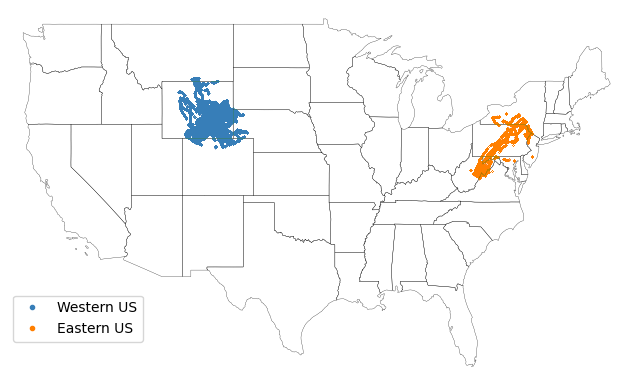

In [7]:
usa = gpd.read_file(os.path.join(data_dir, 'maps', 'usa_states', 'cb_2018_us_state_20m.shp'))
fig, ax = plt.subplots()
#usa.plot(ax=ax, column='GEOID', legend=False, cmap='OrRd', facecolor="none", edgecolor="black")
usa.boundary.plot(ax=ax, linewidth=0.2, color='k')
idf = cdf[(cdf['Group']=='wy') & (cdf['TrackID']>0)]
ax.plot(idf['Longitude'], idf['Latitude'], '.r', color = clrs[0], alpha=0.2, markersize=0.1, label='Western US')
idf = cdf[(cdf['Group']=='pa') & (cdf['TrackID']>0)]
ax.plot(idf['Longitude'], idf['Latitude'], '.b', color = clrs[1], alpha=0.2, markersize=0.1, label='Eastern US')
ax.set_xlim([-126, -66])
ax.set_ylim([25, 50])
#lg = ax.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0., markerscale=60)
lg = ax.legend(bbox_to_anchor=(0.005, 0.2), loc=2, borderaxespad=0., markerscale=60)
for lh in lg.legendHandles: 
    lh.set_alpha(1)
_ = ax.axis(False)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'telemetry_data.png'), dpi=200, bbox_inches='tight')

In [8]:
list_of_series = []
for igroup in ['wy','pa']:
    idf = cdf[cdf['Group']==igroup]
    idata = idf.TimeLocal.dt.month.value_counts().divide(idf.shape[0]/100).sort_index()
    list_of_series.append(idata)
idf = pd.concat(list_of_series, axis=1)
idf.columns = ['Western US', 'Eastern US']

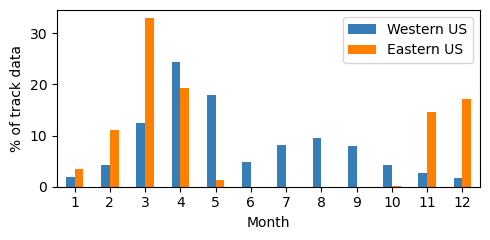

In [9]:
fig, ax = plt.subplots(figsize=(5,2.5))
idf.plot.bar(ax=ax, color=clrs[:2], rot=0)
_ = ax.set_ylabel('% of track data')
_ = ax.set_xlabel('Month')
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'barplot_by_month.png'), dpi=200, bbox_inches='tight')

In [10]:
list_of_series = []
for igroup in ['wy','pa']:
    idf = cdf[cdf['Group']==igroup]
    idata = idf.TimeLocal.dt.hour.value_counts().divide(idf.shape[0]/100).sort_index()
    list_of_series.append(idata)
idf = pd.concat(list_of_series, axis=1)
idf.columns = ['Western US', 'Eastern US']

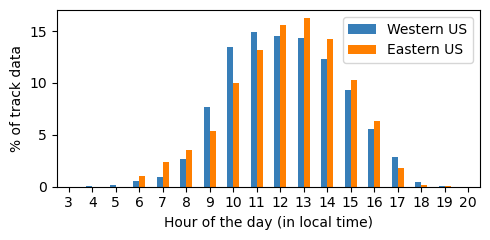

In [11]:
fig, ax = plt.subplots(figsize=(5,2.5))
idf.plot.bar(ax=ax, color=clrs[:2], rot=0)
_ = ax.set_ylabel('% of track data')
_ = ax.set_xlabel('Hour of the day (in local time)')
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'barplot_by_hour.png'), dpi=200, bbox_inches='tight')

In [13]:
for igroup in ['wy','pa']:
    idf = cdf[cdf['Group']==igroup]
    print(igroup, idf.AnimalID.nunique())
    print(igroup, idf.TrackID.nunique())

wy 35
wy 7411
pa 9
pa 607


In [22]:
for igroup in ['wy','pa']:
    idf = vdf[vdf['Group']==igroup]
    jdf = idf[idf.TrackID>0].copy()
    print(jdf.shape[0]/idf.shape[0])
    print(igroup, idf.TimeDiff.value_counts().sort_values(ascending=False).iloc[:10].divide(idf.shape[0]/100))

0.594730604251227
wy 6.0      63.050148
3.0      12.352093
5.0       1.591194
7.0       1.146558
613.0     1.025873
612.0     0.957602
614.0     0.794740
8.0       0.682125
611.0     0.669500
606.0     0.669050
Name: TimeDiff, dtype: float64
0.23796153070145942
pa 6.0     13.267705
10.0     6.978781
9.0      6.598460
4.0      6.466306
8.0      3.743359
1.0      2.830890
5.0      2.276212
32.0     1.880759
33.0     1.667059
3.0      1.529356
Name: TimeDiff, dtype: float64


## plot individual tracks for checking resampling

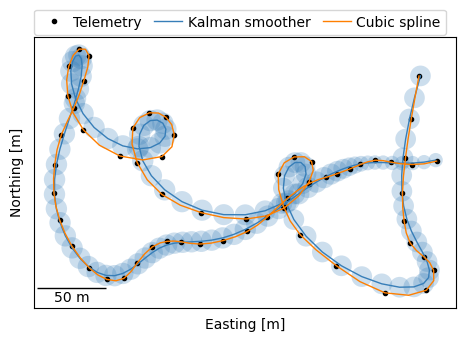

In [23]:
track_id =13
# 13, 10, 90
tstart =10
tduration  =120
fig, ax = plt.subplots(figsize=(5,5))

vtrackdf = vdf[vdf['TrackID']==track_id]
vtrackdf['TrackTimeElapsed'] -= vtrackdf['TrackTimeElapsed'].iloc[0]
vtrackdf = vtrackdf[vtrackdf['TrackTimeElapsed'].between(tstart, tstart+tduration)]

ctrackdf = cdf[cdf['TrackID']==track_id]
ctrackdf['TrackTimeElapsed'] -= ctrackdf['TrackTimeElapsed'].iloc[0]
ctrackdf = ctrackdf[ctrackdf['TrackTimeElapsed'].between(tstart, tstart+tduration)]

ax.plot(vtrackdf['PositionX'],vtrackdf['PositionY'], 'ok', markersize=3., label='Telemetry')
ax.plot(ctrackdf['PositionX'],ctrackdf['PositionY'], '-r', color=clrs[0],linewidth=1., label='Kalman smoother')

covs = [np.diag([ix,ix]) for ix in ctrackdf['PositionX_var'].values]
for xloc, yloc, icov in zip(ctrackdf['PositionX'], ctrackdf['PositionY'], covs):
    width, height, angle = get_covariance_ellipse(icov, 3.)
    ellip = Ellipse(xy=[xloc, yloc], width=width, height=height, angle=angle, fc=clrs[0], alpha=0.25, ec=None)
    ax.add_artist(ellip)
    
etime = vtrackdf['TrackTimeElapsed'].values
fx = interpolate.interp1d(etime, vtrackdf['PositionX'].values, kind='cubic')
fy = interpolate.interp1d(etime, vtrackdf['PositionY'].values, kind='cubic')
itime = np.arange(vtrackdf['TrackTimeElapsed'].iloc[0],vtrackdf['TrackTimeElapsed'].iloc[-1]+1)
xlocs = fx(itime)
ylocs = fy(itime)
ax.plot(xlocs, ylocs, '-r', color=clrs[1], linewidth=1., label='Cubic spline')
#ax.axis('off')
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('Northing [m]')
ax.set_xlabel('Easting [m]')
ax.set_aspect('equal')
my_arrow = AnchoredSizeBar(ax.transData, 50., '50 m', 3, pad=0.1, size_vertical=0.1, frameon=False)
ax.add_artist(my_arrow)
ax.legend(borderaxespad=0., ncol=3, loc=2, columnspacing=0.9, handletextpad=0.4, bbox_to_anchor=(0.,1.1))
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_resampled_space_{track_id}.png'), dpi=200, bbox_inches='tight')

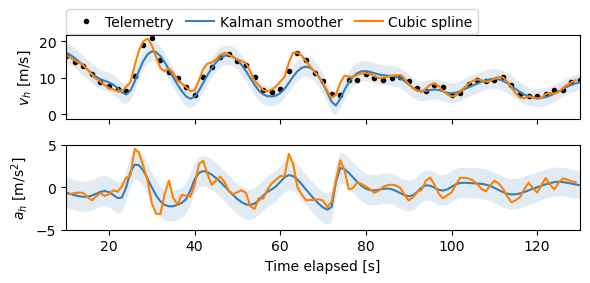

In [24]:
fig, ax = plt.subplots(2,1,figsize=(6,3), sharex=True)
ax[0].plot(vtrackdf['TrackTimeElapsed'],vtrackdf['VelocityHor_TU'],'.k', label='Telemetry')
ax[0].plot(
    ctrackdf['TrackTimeElapsed'],
    ctrackdf['VelocityHor'], '-r', 
    color=clrs[0], 
    linewidth=1.5, 
    label='Kalman smoother'
)
vel_std = np.sqrt((ctrackdf['VelocityX_var'] + ctrackdf['VelocityY_var'])/2)
cb = ax[0].fill_between(
    ctrackdf['TrackTimeElapsed'], 
    ctrackdf['VelocityHor'] - 3.*vel_std, 
    ctrackdf['VelocityHor'] + 3.*vel_std,
    color = clrs[0], 
    alpha=0.15, 
    ec=None
)
hvel = np.sqrt(np.diff(xlocs)**2 + np.diff(ylocs)**2)
#ktime = itime[1:] - itime[1]
ax[0].plot(itime[:-1], hvel, '-r', color=clrs[1], label='Cubic spline')
ax[0].set_ylabel(r'$v_h$ [m/s]')
# heading = vtdf['HeadingHor_TU']
# heading[heading > 180] -= 360
#ax[1].plot(vtdf['TrackTimeElapsed'],heading,'.k')
ax[1].plot(
    ctrackdf['TrackTimeElapsed'],
    ctrackdf['AccnHorTangential'],'-r', 
    color=clrs[0], 
    linewidth=1.5, 
    label='Kalman smoother'
)
vel_std = np.sqrt((ctrackdf['AccelerationX_var'] + ctrackdf['AccelerationY_var'])/2)
cb = ax[1].fill_between(
    ctrackdf['TrackTimeElapsed'], 
    ctrackdf['AccnHorTangential'] - 3.*vel_std, 
    ctrackdf['AccnHorTangential'] + 3.*vel_std,
    color = clrs[0], 
    alpha=0.15, 
    ec=None
)
ax[1].set_ylabel(r'$a_h$ [m/s$^2$]')
ktime = itime[1:-1] - itime[1]
ax[1].plot(itime[1:-1], np.diff(hvel), '-r', color=clrs[1])
# vel_std = np.sqrt((ktdf['VelocityX_var'] + ktdf['VelocityY_var'])/2)
# cb = ax[0].fill_between(
#     ktdf['TrackTimeElapsed'], 
#     ktdf['VelocityHor'] - 2.*vel_std, 
#     ktdf['VelocityHor'] + 2.*vel_std,
#     color = clrs[5], alpha=0.2, ec=None
# )
# hvel = np.degrees(np.arctan2(np.diff(xlocs), np.diff(ylocs,)))
# ax[1].plot(itime[:-1], hvel, '-r', color=clrs[6])
ax[0].set_xlim([itime[0], itime[-1]])
ax[1].set_xlim([itime[0], itime[-1]])
ax[1].set_xlabel('Time elapsed [s]')
ax[1].set_ylim([-5,5])
ax[0].legend(borderaxespad=0., ncol=3, loc=2, columnspacing=0.9, handletextpad=0.4, bbox_to_anchor=(0.,1.3))
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_timehistory_{track_id}.png'), dpi=200, bbox_inches='tight')

## Filter vs Smoother

In [25]:
dftrack = vdf[vdf['TrackID']==track_id]
#dftrack['TrackTimeElapsed'] = dftrack['TrackTimeElapsed'] - dftrack['TrackTimeElapsed'].iloc[0]
track_id = dftrack['TrackID'].iloc[0]
sampler = partial(ConstantAccelerationResampler, dt=1., smoother=True)
rs_x = sampler(error_strength=0.7, flag='X')  # 0.75
rs_x.resample(
    times=dftrack['TrackTimeElapsed'].values,
    locs=dftrack['PositionX'].values,
    error_std=dftrack['ErrorHDOP'].values * 2.5 / np.sqrt(2),
    start_state_std=[4., 2., 2.],
    object_id=track_id
)
rs_y = sampler(error_strength=0.7, flag='Y')  # 0.75
rs_y.resample(
    times=dftrack['TrackTimeElapsed'].values,
    locs=dftrack['PositionY'].values,
    error_std=dftrack['ErrorHDOP'].values * 2.5 / np.sqrt(2),
    start_state_std=[4., 2., 2.],
    object_id=track_id
)

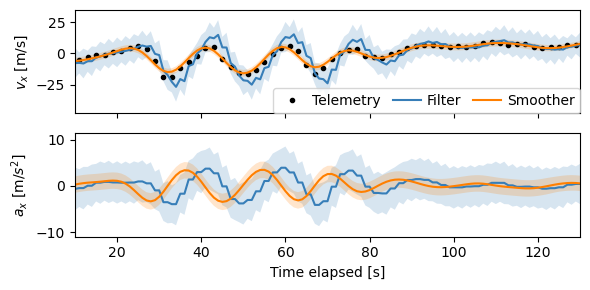

In [26]:
fig, ax = plt.subplots(2,1,figsize=(6,3), sharex=True)
cname = 'VelocityX'
#dftrack['TrackTimeElapsed'] -= dftrack['TrackTimeElapsed'].iloc[0]
ax[0].plot(dftrack['TrackTimeElapsed'],dftrack[f'{cname}_TU'],'.k', label = 'Telemetry')
#rs_x.kf.df['TimeElapsed'] -= rs_x.kf.df['TimeElapsed'].iloc[0]
rs_x.kf.plot_state_mean(cname, ax=ax[0], color=clrs[0], label='Filter')
rs_x.kf.plot_state_cbound(cname, ax=ax[0], alpha=0.2,  color=clrs[0], ec=None)
rs_x.kf.plot_state_mean(cname, ax=ax[0], color=clrs[1], smoother=True, label='Smoother')
rs_x.kf.plot_state_cbound(cname, ax=ax[0], alpha=0.2,  color=clrs[1], smoother=True, ec=None)

cname = 'AccelerationX'
#ax[1].plot(dftrack['TrackTimeElapsed'], dftrack[cname],'.k')
rs_x.kf.plot_state_mean(cname, ax=ax[1], color=clrs[0])
rs_x.kf.plot_state_cbound(cname, ax=ax[1], alpha=0.2,  color=clrs[0], ec=None)
rs_x.kf.plot_state_mean(cname, ax=ax[1], color=clrs[1], smoother=True)
rs_x.kf.plot_state_cbound(cname, ax=ax[1], alpha=0.2,  color=clrs[1], smoother=True, ec=None)

# itime = [80,100]
ax[0].set_xlim([itime[0], itime[-1]])
ax[1].set_xlim([itime[0], itime[-1]])
ax[0].set_xlabel('')
ax[1].set_xlabel('Time elapsed [s]')
ax[0].set_ylabel(r'$v_x$ [m/s]')
ax[1].set_ylabel(r'$a_x$ [m/$s^2$]')
fig.tight_layout()
ax[0].legend(borderaxespad=0., ncol=3, loc=4, columnspacing=0.9, handletextpad=0.4)
fig.savefig(os.path.join(FIG_DIR,f'fig_fVSs_{track_id}.png'), dpi=200, bbox_inches='tight')